## Learning to learn by gradient descent by gradient descent

In this notebook, we try GRU instead of LSTM netowrks as optimizers

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import glob
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.autograd as autograd
import torch.optim as optim
from torch.autograd import Variable
from torchvision import datasets
import torchvision
from torchsummary import summary

import matplotlib.pyplot as plt
import random
from tqdm import tqdm_notebook as tqdm
import multiprocessing
import os.path
from os import path
import csv
import copy
import joblib
import seaborn as sns; sns.set(color_codes=True)
sns.set_style("white")
from pdb import set_trace as bp

In [3]:
USE_CUDA = torch.cuda.is_available()

def w(v):
    if USE_CUDA:
        return v.cuda()
    return v

In [4]:
if not path.isdir('cache'):
    !mkdir cache
cache = joblib.Memory(location='cache', verbose=0)

In [5]:
from meta_module import *

## Gradient detach

As we perform operations, Pytorch builds the computational graph of the operations we perform. However, there are some variables that we want to detach from the graph at various points, specifically we want to pretend that the **gradients are inputs** (as specified in the previous image) that come from nowhere, instead of coming from the rest of the computational graph as they really do: this means we want to **detach** the gradients from the graph. Likewise, when every 20 steps we perform backpropagation on the optimizer network, we want the current hidden states and cell states, as well as the parameters of the optimizee to "forget" that they are dependent on previous steps in the graph. For all of this, I created a function called `detach_var` which creates a new Variable from the current variable's data, and makes sure that its gradients are still kept. This is different from the `.detach()` function in Pytorch which does not quite forget the original graph and also does not guarantee that the gradients will be there.

In [6]:
def detach_var(v):
    var = w(Variable(v.data, requires_grad=True))
    var.retain_grad()
    return var

import functools

def rsetattr(obj, attr, val):
    pre, _, post = attr.rpartition('.')
    return setattr(rgetattr(obj, pre) if pre else obj, post, val)

# using wonder's beautiful simplification: https://stackoverflow.com/questions/31174295/getattr-and-setattr-on-nested-objects/31174427?noredirect=1#comment86638618_31174427

def rgetattr(obj, attr, *args):
    def _getattr(obj, attr):
        return getattr(obj, attr, *args)
    return functools.reduce(_getattr, [obj] + attr.split('.'))

## Training functions for Optimizer Network

In [7]:
def do_fit(optimizer_net, meta_opt, cost_cls, target_to_opt, unroll, optim_it, n_epochs, out_mul, preproc = True, should_train=True):

    r""""
    
    Input variables:

    optimizer_net:      optimizer network class
    meta_opt:           optimizer method for the optimizer, in this notebook we use ADAM
    cost_cls:           cost/loss function
    target_to_opt:      optimizee class
    optim_it, unroll:   Each epoch is made up of trying to optimize a new random function for 'optim_it' steps, 
                        but we are doing an update of the optimizer every 'unroll' steps.                       
    n_epochs:           number of epochs
    out_mul:            learning rate for update parameters in the optimizee network?
    params:             number of parameters of the omptimizee network
    """

    ## ---- DEFINE OBJETIVE OF THE FUNCTION ---- ##
    ## ----         TRAIN  or TEST          ---- ##
    
    if should_train:
        optimizer_net.train()
    else:
        optimizer_net.eval()
        unroll = 1

    ## ---- INITIALIZE CLASSES AND VARIABLES ---- ##    
    target = cost_cls(training=should_train)
    optimizee = w(target_to_opt())
    n_params = 0

    ## ---- RETRIEVE NUMBER OF PARAMETERS IN ---- ##
    ## ----       OPTIMIZEE NETWORK           ----##
    
    for name, p in optimizee.all_named_parameters():
        n_params += int(np.prod(p.size()))
        
    ## ---- INITIALIZE HIDDEN STATES  ----##
    hidden_states = [w(Variable(torch.zeros(n_params, optimizer_net.hidden_sz))) for _ in range(2)]
        
    ## ---- INITIALIZE THE VECTOR CONTAINING  ----##
    ## ---- THE CUMULATIVE LOSS OVER THE LOOP ----##
    
    all_losses_ever = []

    ## ---- RESTART THE GRADIENTS OF THE META-OPT ----##
    ## ----        FOR TRAINING PHASE             ----##
    
    if should_train:
        meta_opt.zero_grad()

    # Compute the loss of the optimizee and compute the #
    # cumulative loss over all iterations.              #
    
    all_losses = None

    
    for iteration in range(1, optim_it + 1):
        loss = optimizee(target)
                    
        if all_losses is None:
            all_losses = loss
        else:
            all_losses += loss
            
        # Appends the current individual loss to a file
        all_losses_ever.append(loss.data.cpu().numpy())
        
        # Compute optimizee's backward propagation of the loss and retain_graph to be used when optimizing the optimizer.
        loss.backward(retain_graph=should_train)

       
        offset = 0
        result_params = {}
        # New temporary variable inside the loop
        hidden_states2 = [w(Variable(torch.zeros(n_params, optimizer_net.hidden_sz))) for _ in range(2)]

        # Update each parameters and the cell and hidden states by iterating through the optimizee's "all_named_parameters".
        for name, p in optimizee.all_named_parameters():
            cur_sz = int(np.prod(p.size()))

            # We do this so the gradients are disconnected from the graph but we still get
            # gradients from the rest
            gradients = detach_var(p.grad.view(cur_sz, 1))
            
            # The gradients are fed to the optimizer network as a flatenned layer (1D)
            updates, new_hidden = optimizer_net(gradients, [h[offset:offset+cur_sz] for h in hidden_states])
            
            for i in range(len(new_hidden)):
                hidden_states2[i][offset:offset+cur_sz] = new_hidden[i]

            # Updated parameters of the optimizee function    
            result_params[name] = p + updates.view(*p.size()) * out_mul
            
            # The resulting variable isn't a leaf, which means it won't retain grads by default.
            result_params[name].retain_grad()
            
            offset += cur_sz
            
        # Update the optimizer parameters if    
        if iteration % unroll == 0:
            if should_train:
                meta_opt.zero_grad()
                all_losses.backward()
                meta_opt.step()

            # Restart the losses    
            all_losses = None

            # Train a new random network with the last parameters obtained and reinitialize the grad
            optimizee = w(target_to_opt())
            optimizee.load_state_dict(result_params)
            optimizee.zero_grad()
            hidden_states = [detach_var(v) for v in hidden_states2]
            
        else:
            for name, p in optimizee.all_named_parameters():
                rsetattr(optimizee, name, result_params[name])
            assert len(list(optimizee.all_named_parameters()))
            hidden_states = hidden_states2
            
    return all_losses_ever


# @cache.cache
def fit_optimizer(cost_cls, target_to_opt, preproc=False, unroll=20, optim_it=100, n_epochs=20, n_tests=100, lr=0.001, out_mul=1.0):

    # Call the GRU Optimizer network
    optimizer_net = w(Optimizer(preproc=preproc))

    # Choose the optimizer that will optimize the Transformer network
    # i.e.: the meta-optimizer
    meta_opt = optim.Adam(optimizer_net.parameters(), lr=lr)
    
    best_net = None
    best_loss = 100000000000000000
    
    for _ in tqdm(range(n_epochs), 'epochs'):
        for _ in tqdm(range(20), 'iterations'):
            do_fit(optimizer_net, meta_opt, cost_cls, target_to_opt, unroll, optim_it, n_epochs, out_mul, should_train=True)
        
        loss = (np.mean([
            np.sum(do_fit(optimizer_net, meta_opt, cost_cls, target_to_opt, unroll, optim_it, n_epochs, out_mul, should_train=False))
            for _ in tqdm(range(n_tests), 'tests')
        ]))
        
        print(loss)
        if loss < best_loss:
            print(best_loss, loss)
            best_loss = loss
            best_net = copy.deepcopy(optimizer_net.state_dict())
            
    return best_loss, best_net

## Optimizer network: PyTorch GRU
In this new re-implementation we will use a GRU as the Optimizer instead of a LSTM.

Below, the Optimizer is initialized. The amount of hidden units in each layer is 20, as in the paper. The gradients preprocessing uses the same value (10), and later in forward the corresponding steps are performed so the gradient do not propage through the input. There are two GRU layers, in a similar fashion of that what is done in the paper with LSTM.

In [8]:
class Optimizer(nn.Module):
    def __init__(self, preproc=False, hidden_sz=20, preproc_threshold=10.0):
        super().__init__()

        
        self.hidden_sz = hidden_sz

        # In Appendix A of Learning to Learn (by Gradient Descent)^2 
        # the preprocessing steps are explained. 
        # Due to the preprocessing, there will be two outputs 
        # instead of one that will be fed to the  GRU.
        # Therefore, there are two different cells
        # One for preprocessing and one without.
        
        if preproc:
            self.recursive_cell = nn.GRUCell(2, hidden_sz)
        else:
            self.recursive_cell = nn.GRUCell(1, hidden_sz)

        self.recursive_cell2 = nn.GRUCell(hidden_sz, hidden_sz)
        self.output = nn.Linear(hidden_sz, 1)

        self.preproc = preproc
        self.preproc_factor = preproc_threshold
        
    def forward(self, gradients, hidden):

        # Implement preproc described in Appendix A
        # if True

        if self.preproc:
            gradients = gradients.data
            log = torch.log(torch.abs(gradients))
            clamp_log = torch.clamp(log/self.preproc_factor , min = -1.0,max = 1.0)
            clamp_sign = torch.clamp(torch.exp(w(torch.tensor(self.preproc_factor)))*gradients, min = -1.0, max =1.0)
            gradients = torch.cat((clamp_log,clamp_sign), dim = -1)

        # Perform the actual forward operations
        # Input the data to the first GRU Cell
        hidden0 = self.recursive_cell(gradients, hidden[0])

        # Use the hidden state of the previous GRU Cell and the second hidden state from the input
        hidden1 = self.recursive_cell2(hidden0,  hidden[1])
 
        return self.output(hidden1), (hidden0, hidden1)

# Optimizee Network: Quadratic functions

The optimizer is supposed to find a 10-element vector called $\theta$ that, when multiplied by a 10x10 matrix called $W$, is as close as possible to a 10-element vector called $y$. Both $y$ and $W$ are generated randomly. The error is simply the squared error.

## Class and function definitions

In [9]:
class QuadraticLoss:
    def __init__(self, **kwargs):
        self.W = w(Variable(torch.randn(10, 10)))
        self.y = w(Variable(torch.randn(10)))
        
    def get_loss(self, theta):
        return torch.sum((self.W.matmul(theta) - self.y)**2)
    
class QuadOptimizee(MetaModule):
    def __init__(self, theta=None):
        super().__init__()
        self.register_buffer('theta', to_var(torch.zeros(10).cuda(), requires_grad=True))
        
    def forward(self, target):
        return target.get_loss(self.theta)
    
    def parameters(self):
        return [self.theta]
    
    def all_named_parameters(self):
        return [('theta', self.theta)]

## Find best learning rate for meta_optimizer
The experiment below fits various learning rates that are used in the meta_optimizer (ADAM).

In [ ]:
for lr in tqdm([0.03, 0.01, 0.003, 0.001, 0.0003, 0.0001], 'all'):
    print('Learning rate:', lr)
    print(fit_optimizer(QuadraticLoss, QuadOptimizee, lr=lr, n_epochs=10)[0])

The experiment shows that 0.003 is a promising learning rate. It is not the lowest, but we are training on only 20 epochs by default and will then retrain with 100 epochs, so it is good to have a slightly lower learning rate for training for longer.

Next, the final model is trained with the learning rate (lr = 0.003) found in the previous block and the number of epochs are increased to 100.

In [ ]:
import time
start_time = time.time()
loss, quad_optimizer = fit_optimizer(QuadraticLoss, QuadOptimizee, lr=0.003, n_epochs=100)
end_time = time.time()
print('The GRU model loss with the best found learning rate is: ', loss)
print("Training duration: %s" % (time.time() - start_time))

In [ ]:
start_time03 = time.time()
loss03, quad_optimizer03 = fit_optimizer(QuadraticLoss, QuadOptimizee, lr=0.03, n_epochs=100)
print('The GRU model loss with the best found learning rate is: ', loss03)
print("Training duration: %s" % (time.time() - start_time03))

In [ ]:
torch.save(quad_optimizer, 'gru_opt_quad_003.pth')

## Find best learning rate for conventional optimizers

The following two functions are used to find the best learning rate for conventional optimizers: ADAM, RMSProp, SGD and NAG. 

In [11]:
@cache.cache
def fit_normal(target_cls, target_to_opt, opt_class, n_tests=100, n_epochs=100, **kwargs):
    results = []
    for i in tqdm(range(n_tests), 'tests'):
        target = target_cls(training=False)
        optimizee = w(target_to_opt())
        optimizer = opt_class(optimizee.parameters(), **kwargs)
        total_loss = []
        for _ in range(n_epochs):
            loss = optimizee(target)
            
            total_loss.append(loss.data.cpu().numpy())
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        results.append(total_loss)
    return results

def find_best_lr_normal(target_cls, target_to_opt, opt_class, **extra_kwargs):
    best_loss = 1000000000000000.0
    best_lr = 0.0
    for lr in tqdm([1.0, 0.3, 0.1, 0.03, 0.01, 0.003, 0.001, 0.0003, 0.0001, 0.00003, 0.00001], 'Learning rates'):
        try:
            loss = best_loss + 1.0
            loss = np.mean([np.sum(s) for s in fit_normal(target_cls, target_to_opt, opt_class, lr=lr, **extra_kwargs)])
        except RuntimeError:
            pass
        if loss < best_loss:
            best_loss = loss
            best_lr = lr
    return best_loss, best_lr

In [12]:
NORMAL_OPTS = [(optim.Adam, {}), (optim.RMSprop, {}), (optim.SGD, {'momentum': 0.9}), (optim.SGD, {'nesterov': True, 'momentum': 0.9})]
OPT_NAMES = ['ADAM', 'RMSprop', 'SGD', 'NAG']

In [ ]:
# NB: the momentum parameter for nesterov was found from the following file: 
#https://github.com/torch/optim/blob/master/nag.lua  since it is mentioned
# n the paper that "When an optimizer has more parameters than just a learning rate (e.g. decay coefficients for ADAM) 
#we use the default values from the optim package in Torch7."

for opt, kwargs in NORMAL_OPTS:
    print(find_best_lr_normal(QuadraticLoss, QuadOptimizee, opt, **kwargs))

In the cell below:

- QUAD_LRS are the best learning rates obtained for the conventional optimizers
- fit_data is initialized to 0 and the third dimension has length equal to all conventional opt. + Transformer
- The data is fitted with the best learning rate for conventional optimizers.
- The state_dict of the optimizer network found in the previous section is loaded
- Why is it fitted again I don't know    

In [ ]:
QUAD_LRS = [0.1, 0.03, 0.01, 0.01]
fit_data = np.zeros((100, 100, len(OPT_NAMES) + 1))
for i, ((opt, extra_kwargs), lr) in enumerate(zip(NORMAL_OPTS, QUAD_LRS)):
    np.random.seed(0)
    fit_data[:, :, i] = np.array(fit_normal(QuadraticLoss, QuadOptimizee, opt, lr=lr, **extra_kwargs))

opt = w(Optimizer())
opt.load_state_dict(quad_optimizer)
np.random.seed(0)
fit_data[:, :, len(OPT_NAMES)] = np.array([do_fit(opt, None, QuadraticLoss, QuadOptimizee, 1, 100, 100, out_mul=1.0, should_train=False) for _ in range(100)])
# fit_data[:, :, len(OPT_NAMES) + 1] = np.load("fitted_lstm_003.npy")

## Graphical results

Here, our results are shown:

In [ ]:
ax = sns.tsplot(data=fit_data[:, :, :], condition=OPT_NAMES + ['GRU'], linestyle='--', color=['r', 'b', 'g', 'k', 'y'])
ax.lines[-1].set_linestyle('-')
ax.legend()
plt.yscale('log')
plt.xlabel('steps')
plt.ylabel('loss')
plt.grid()
plt.title('Quadratic functions')
plt.savefig('quadratic_results_gru_6apr.png', dpi=300)
plt.show()

## Combine GRU and LSTM plots

In [ ]:
QUAD_LRS = [0.1, 0.03, 0.01, 0.01]
fit_data = np.zeros((100, 100, len(OPT_NAMES) + 2))
for i, ((opt, extra_kwargs), lr) in enumerate(zip(NORMAL_OPTS, QUAD_LRS)):
    np.random.seed(0)
    fit_data[:, :, i] = np.array(fit_normal(QuadraticLoss, QuadOptimizee, opt, lr=lr, **extra_kwargs))

opt = w(Optimizer())
opt.load_state_dict(quad_optimizer)
np.random.seed(0)
fit_data[:, :, len(OPT_NAMES)] = np.array([do_fit(opt, None, QuadraticLoss, QuadOptimizee, 1, 100, 100, out_mul=1.0, should_train=False) for _ in range(100)])
fit_data[:, :, len(OPT_NAMES) + 1] = np.load("lstm_003_6april.npy")

In [ ]:
ax = sns.tsplot(data=fit_data[:, :, :], condition=OPT_NAMES + ['GRU', 'LSTM'], linestyle='--', color=['r', 'b', 'g', 'k', 'y', 'c'])
ax.lines[-1].set_linestyle('-')
ax.legend()
plt.yscale('log')
plt.xlabel('steps')
plt.ylabel('loss')
plt.grid()
plt.title('Quadratic functions')
# plt.savefig('quadratic_results_gru_lstm_6apr.png', dpi=300)
plt.show()

In [ ]:
ax = sns.tsplot(data=fit_data[:, :, :], condition=OPT_NAMES + ['GRU', 'LSTM'], linestyle='--', color=['r', 'b', 'g', 'k', 'y', 'c'])
ax.lines[-1].set_linestyle('-')
ax.legend()
plt.yscale('log')
plt.xlabel('steps')
plt.ylabel('loss')
plt.grid()
plt.title('Quadratic functions')
# plt.savefig('quadratic_results_gru_lstm_6apr.png', dpi=300)
plt.show()

# Optimizee network: MNIST

In [13]:
class MNISTLoss:
    def __init__(self, training=True):
        dataset = datasets.MNIST(
            '/home/chenwy/mnist', train=True, download=True,
            transform=torchvision.transforms.ToTensor()
        )
        indices = list(range(len(dataset)))
        np.random.RandomState(10).shuffle(indices)
        if training:
            indices = indices[:len(indices) // 2]
        else:
            indices = indices[len(indices) // 2:]

        self.loader = torch.utils.data.DataLoader(
            dataset, batch_size=128,
            sampler=torch.utils.data.sampler.SubsetRandomSampler(indices))

        self.batches = []
        self.cur_batch = 0 #current batch
        
    def sample(self):
        if self.cur_batch >= len(self.batches):
            self.batches = []
            self.cur_batch = 0
            for b in self.loader:
                self.batches.append(b)
        batch = self.batches[self.cur_batch]
        self.cur_batch += 1
        return batch

class MNISTNet(MetaModule):
    def __init__(self, layer_size=20, n_layers=1, **kwargs):
        super().__init__()

        inp_size = 28*28
        self.layers = {}
        for i in range(n_layers):
            self.layers[f'mat_{i}'] = MetaLinear(inp_size, layer_size)
            inp_size = layer_size

        self.layers['final_mat'] = MetaLinear(inp_size, 10)
        self.layers = nn.ModuleDict(self.layers)

        self.activation = nn.Sigmoid()
        self.loss = nn.NLLLoss()

    def all_named_parameters(self):
        return [(k, v) for k, v in self.named_parameters()]
    
    def forward(self, loss):
        inp, out = loss.sample()
        inp = w(Variable(inp.view(inp.size()[0], 28*28)))
        out = w(Variable(out))

        cur_layer = 0 #current layer
        while f'mat_{cur_layer}' in self.layers:
            inp = self.activation(self.layers[f'mat_{cur_layer}'](inp))
            cur_layer += 1

        inp = F.log_softmax(self.layers['final_mat'](inp), dim=1)
        l = self.loss(inp, out)
        return l

## Find best learning rate for meta_optimizer
The experiment below fits various learning rates that are used in the meta_optimizer (ADAM)

In [ ]:
for lr in tqdm(sorted([0.01, 0.003, 0.001, 0.0003, 0.0001], key=lambda x: np.abs(x - 0.003)), 'all'):
    print('Trying lr:', lr)
    print(fit_optimizer(MNISTLoss, MNISTNet, lr=lr, out_mul=0.1, preproc=True, n_tests=5, n_epochs=10)[0])

The experiment shows that 0.01 is a promising learning rate. It is not the lowest, but we are training on only 20 epochs by default and will then retrain with 100 epochs, so it is good to have a slightly lower learning rate for training for longer.

Next, the final model is trained with the learning rate (lr = 0.01) found in the previous block and the number of epochs are increased to 100.

In [14]:
loss, mnist_optimizer = fit_optimizer(MNISTLoss, MNISTNet, lr=0.003, n_epochs=100, n_tests=20, out_mul=0.1, preproc=True)
print('The GRU model loss with the best found learning rate is: ', loss)

72.10045
100000000000000000 72.10045


60.599274
72.10045 60.599274


59.188873
60.599274 59.188873


57.83789
59.188873 57.83789


55.98017
57.83789 55.98017


58.264263


60.14332


58.57818


60.915203


58.45049


59.393604


58.405834


59.72583


58.963356


56.687073


63.315193


56.21583


57.58117


59.40856


58.164925


55.6195
55.98017 55.6195


56.34495


57.608856


59.218315


59.549877


57.17321


60.507057


60.045002


55.959343


63.68064


59.36593


62.076378


57.39625


60.709595


60.453346


61.361137


55.474693
55.6195 55.474693


60.483856


59.73812


58.763836


57.780132


61.38032


61.784058


55.449303
55.474693 55.449303


58.27299


58.523487


57.16873


56.519672


58.21708


55.479225


59.53596


58.431152


62.586113


56.6828


51.295753
55.449303 51.295753


61.237896


56.28236


51.95094


56.76845


54.673237


64.91218


59.298847


68.65891


50.902336
51.295753 50.902336


62.43232


60.78959


59.16996


56.246082


59.167213


58.585682


58.450096


57.030834


58.879803


56.652424


65.354744


57.13091


56.117695


56.10144


60.54281


58.233387


54.711266


60.113995


59.067303


52.579712


55.18382


61.08468


57.387093


53.28408


53.943066


52.891754


57.836296


55.48363


54.21352


51.871593


52.354073


50.512936
50.902336 50.512936


54.582176


55.17793


63.16053


53.238598
The GRU model loss with the best found learning rate is:  50.512936


## Find best learning rate for conventional optimizers

The following two functions are used to find the best learning rate for conventional optimizers: ADAM, RMSProp, SGD and NAG. 

In [ ]:
for opt, kwargs in NORMAL_OPTS:
    print(find_best_lr_normal(MNISTLoss, MNISTNet, opt, **kwargs, n_tests=10))

The best learning rates found are used to compare it with the GRU Optimizer

In [42]:
QUAD_LRS = [0.03, 0.01, 1.0, 1.0]
N_TESTS = 100

fit_data = np.zeros((N_TESTS, 200, len(OPT_NAMES) + 2))
for i, ((opt, extra_kwargs), lr) in enumerate(zip(NORMAL_OPTS, QUAD_LRS)):
    np.random.seed(0)
    fit_data[:, :, i] = np.array(fit_normal(MNISTLoss, MNISTNet, opt, lr=lr, n_tests=N_TESTS, n_epochs=200, **extra_kwargs))

In [43]:
@cache.cache
def get_fit_dict_test(n_tests, opt_dict, *args, **kwargs):
    opt = w(Optimizer(preproc=True))
    opt.load_state_dict(opt_dict)
    np.random.seed(0)
    return [do_fit(opt, *args, **kwargs) for _ in tqdm(range(N_TESTS), 'optimizer')]
fit_data[:, :, len(OPT_NAMES)] = np.array(get_fit_dict_test(N_TESTS, mnist_optimizer, None, MNISTLoss, MNISTNet, 1, 200, 200, out_mul=0.1, should_train=False))

In [17]:
np.save('gru_mnist_lr_003.npy', fit_data[:,:, len(OPT_NAMES)])

In [44]:
fit_data[:, :, len(OPT_NAMES) + 1] = np.load("mnist_lstm.npy")

### Graphical Results

C:\Users\kevin\anaconda3\envs\L2L\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)
C:\Users\kevin\anaconda3\envs\L2L\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
C:\Users\kevin\anaconda3\envs\L2L\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either 

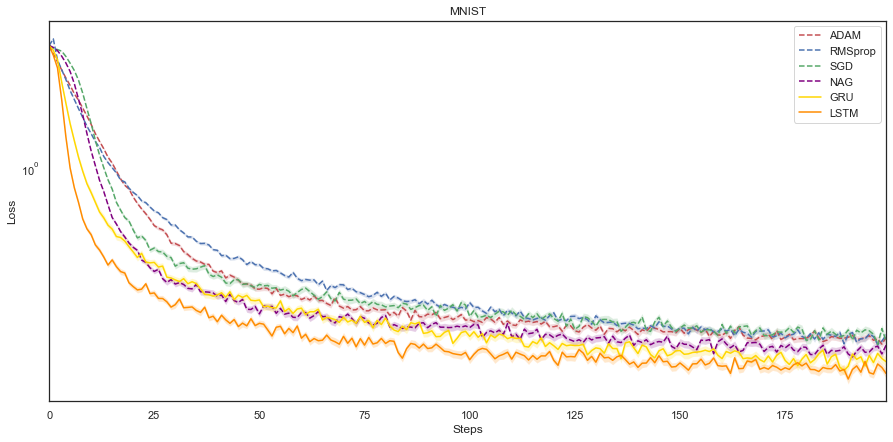

In [45]:
plt.figure(figsize=(15,7))
ax = sns.tsplot(data=fit_data[:, :, :], condition=OPT_NAMES + ['GRU', 'LSTM'], linestyle='--', color=['r', 'b', 'g', 'purple', 'gold', 'darkorange'])
ax.lines[-1].set_linestyle('-')
ax.lines[-2].set_linestyle('-')
ax.legend()
plt.yscale('log')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.title('MNIST')
plt.savefig('MNIST_results_gru.png')
plt.show()

# Extend MNIST Results

After performing the first comparison we look at variations of the MNIST optimizee network: a 2 layer feedforward with 20 units per layer network, a 40 units 1-layer network, and 1-layer network with ReLU activation. 

In [20]:
class MNISTNet2Layer(MNISTNet):
    def __init__(self, *args, **kwargs):
        super().__init__(n_layers=2, *args, **kwargs)
        
class MNISTNetBig(MNISTNet):
    def __init__(self, *args, **kwargs):
        super().__init__(layer_size=40, *args, **kwargs)
        
class MNISTRelu(MNISTNet):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.activation = nn.ReLU()

Again, we look for the best learning rates for the conventional optimizers.

In [ ]:
for opt, kwargs in NORMAL_OPTS:
    print(find_best_lr_normal(MNISTLoss, MNISTNet2Layer, opt, **kwargs, n_tests=10))

for opt, kwargs in NORMAL_OPTS:
    print(find_best_lr_normal(MNISTLoss, MNISTNetBig, opt, **kwargs, n_tests=10))

for opt, kwargs in NORMAL_OPTS:
    print(find_best_lr_normal(MNISTLoss, MNISTRelu, opt, **kwargs, n_tests=10))

The best results (QUAD_LRS) are used for the comparison.

## MNIST 2 layers

In [46]:
QUAD_LRS = [0.01, 0.003, 0.03, 1.0]
N_TESTS = 100

fit_data = np.zeros((N_TESTS, 200, len(OPT_NAMES) + 2))
for i, ((opt, extra_kwargs), lr) in enumerate(zip(NORMAL_OPTS, QUAD_LRS)):
    np.random.seed(0)
    fit_data[:, :, i] = np.array(fit_normal(MNISTLoss, MNISTNet2Layer, opt, lr=lr, n_tests=N_TESTS, n_epochs=200, **extra_kwargs))

fit_data[:, :, len(OPT_NAMES)] = np.array(get_fit_dict_test(N_TESTS, mnist_optimizer, None, MNISTLoss, MNISTNet2Layer, 1, 200, 200, out_mul=0.1, should_train=False))

In [47]:
fit_data[:, :, len(OPT_NAMES) + 1] = np.load("mnist2layer_lstm.npy")

### Graphical results: MNIST optimizee with 2 layers - GRU Optimizer

C:\Users\kevin\anaconda3\envs\L2L\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)
C:\Users\kevin\anaconda3\envs\L2L\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
C:\Users\kevin\anaconda3\envs\L2L\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either 

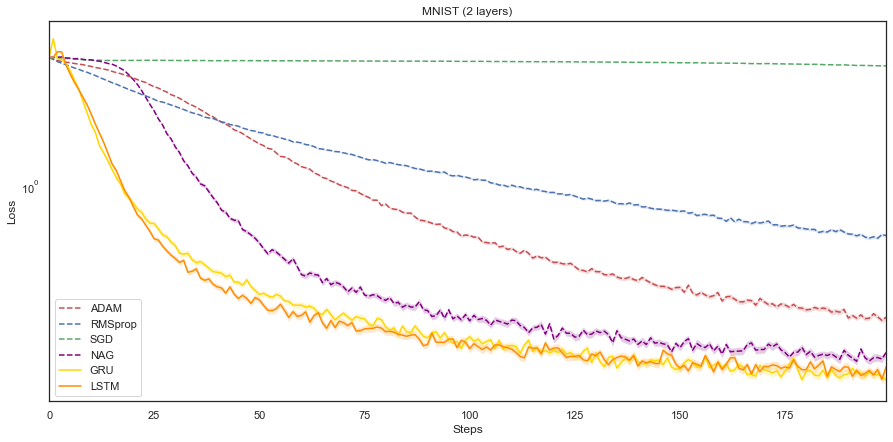

In [48]:
plt.figure(figsize=(15,7))
ax = sns.tsplot(data=fit_data[:, :, :], condition=OPT_NAMES + ['GRU', 'LSTM'], linestyle='--', color=['r', 'b', 'g', 'purple', 'gold', 'darkorange'])
ax.lines[-1].set_linestyle('-')
ax.lines[-2].set_linestyle('-')
ax.legend()
plt.yscale('log')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.title('MNIST (2 layers)')
plt.savefig('MNIST_results_GRU_2layers.png')
plt.show()

## MNIST 40 units

In [49]:
QUAD_LRS = [0.03, 0.01, 1.0, 1.0]
N_TESTS = 100

fit_data = np.zeros((N_TESTS, 200, len(OPT_NAMES) + 2))
for i, ((opt, extra_kwargs), lr) in enumerate(zip(NORMAL_OPTS, QUAD_LRS)):
    np.random.seed(0)
    fit_data[:, :, i] = np.array(fit_normal(MNISTLoss, MNISTNetBig, opt, lr=lr, n_tests=N_TESTS, n_epochs=200, **extra_kwargs))

fit_data[:, :, len(OPT_NAMES)] = np.array(get_fit_dict_test(N_TESTS, mnist_optimizer, None, MNISTLoss, MNISTNetBig, 1, 200, 200, out_mul=0.1, should_train=False))

In [50]:
fit_data[:, :, len(OPT_NAMES) + 1] = np.load("mnist_lstm_40units.npy")

### Graphical results: MNIST optimizee with 40 Units - GRU Optimizer

C:\Users\kevin\anaconda3\envs\L2L\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)
C:\Users\kevin\anaconda3\envs\L2L\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
C:\Users\kevin\anaconda3\envs\L2L\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either 

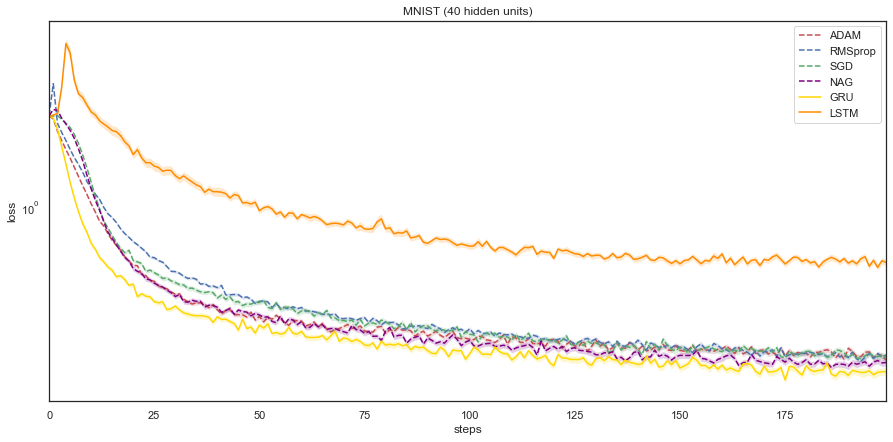

In [51]:
plt.figure(figsize=(15,7))
ax = sns.tsplot(data=fit_data[:, :, :], condition=OPT_NAMES + ['GRU', 'LSTM'], linestyle='--', color=['r', 'b', 'g', 'purple', 'gold', 'darkorange'])
ax.lines[-1].set_linestyle('-')
ax.lines[-2].set_linestyle('-')
ax.legend()
plt.yscale('log')
plt.xlabel('steps')
plt.ylabel('loss')
plt.title('MNIST (40 hidden units)')
plt.savefig('MNIST_results_gru_40units.png')

plt.show()

## MNIST ReLU Activation

In [52]:
QUAD_LRS = [0.03, 0.003, 0.3, 0.3]
N_TESTS = 100

fit_data = np.zeros((N_TESTS, 200, len(OPT_NAMES) + 2))
for i, ((opt, extra_kwargs), lr) in enumerate(zip(NORMAL_OPTS, QUAD_LRS)):
    np.random.seed(0)
    fit_data[:, :, i] = np.array(fit_normal(MNISTLoss, MNISTRelu, opt, lr=lr, n_tests=N_TESTS, n_epochs=200, **extra_kwargs))

fit_data[:, :, len(OPT_NAMES)] = np.array(get_fit_dict_test(N_TESTS, mnist_optimizer, None, MNISTLoss, MNISTRelu, 1, 200, 200, out_mul=0.1, should_train=False))

In [53]:
fit_data[:, :, len(OPT_NAMES) + 1] = np.load("mnist_lstm_relu.npy")

### Graphical results: MNIST optimizee with ReLU Activation - GRU Optimizer

C:\Users\kevin\anaconda3\envs\L2L\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)
C:\Users\kevin\anaconda3\envs\L2L\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
C:\Users\kevin\anaconda3\envs\L2L\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either 

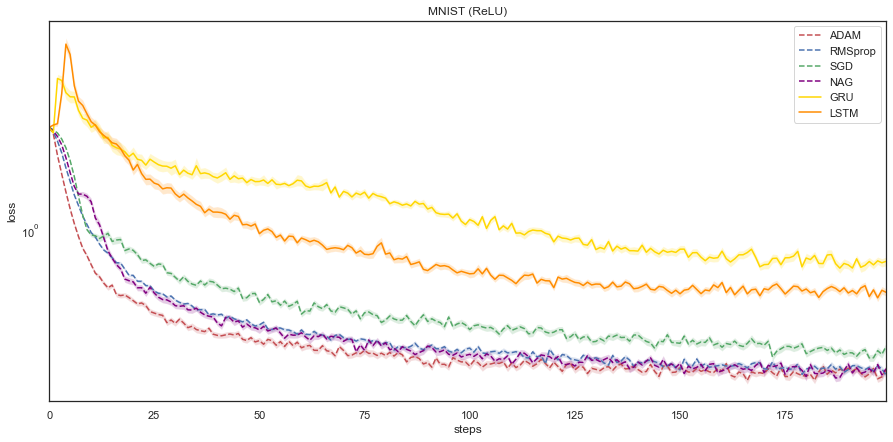

In [54]:
plt.figure(figsize=(15,7))
ax = sns.tsplot(data=fit_data[:, :, :], condition=OPT_NAMES + ['GRU', 'LSTM'], linestyle='--', color=['r', 'b', 'g', 'purple', 'gold', 'darkorange'])
ax.lines[-1].set_linestyle('-')
ax.lines[-2].set_linestyle('-')
ax.legend()
plt.yscale('log')
plt.xlabel('steps')
plt.ylabel('loss')
plt.title('MNIST (ReLU)')
plt.savefig('MNIST_results_gru_relu.png')
plt.show()